In [32]:
import pandas as pd
import os 
import numpy as np
import cv2
from matplotlib.pyplot import imread
import matplotlib.pyplot as plt
import random as rn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import numpy as np
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import matplotlib.pyplot as plt

In [7]:
def load_camera_data(cam_id):
    base_path = 'dataset'
    image = f'{base_path}/cam_{cam_id}.npy'
    name = f'{base_path}/name_{cam_id}.npy'
    label = f'{base_path}/label_{cam_id}.npy'
    return np.load(image), np.load(label), np.load(name)

In [8]:
cam_1, label_1, name_1 = load_camera_data('1')
cam_2, label_2, name_2 = load_camera_data('2')

print('#1')
print(len(cam_1))
print(len(label_1))
print(len(name_1))

print('\n#2')
print(len(cam_2))
print(len(label_2))
print(len(name_2))

#1
23442
23442
23442

#2
23442
23442
23442


In [9]:
SUB = pd.read_csv('dataset/sensor.csv', skiprows = 1)
SUB.head()

times = SUB['Time']

In [10]:
redundant_1 = list(set(name_1) - set(times))
redundant_2 = list(set(name_2) - set(times))
ind = np.arange(0, len(cam_1))


red_in1 = ind[np.isin(name_1,redundant_1)]
name_1 =  np.delete(name_1, red_in1)
cam_1 = np.delete(cam_1, red_in1, axis = 0 )
label_1 = np.delete(label_1, red_in1)

red_in2 = ind[np.isin(name_2,redundant_2)]
name_2 =  np.delete(name_2, red_in2)
cam_2 = np.delete(cam_2, red_in2, axis = 0 )
label_2 = np.delete(label_2, red_in2)

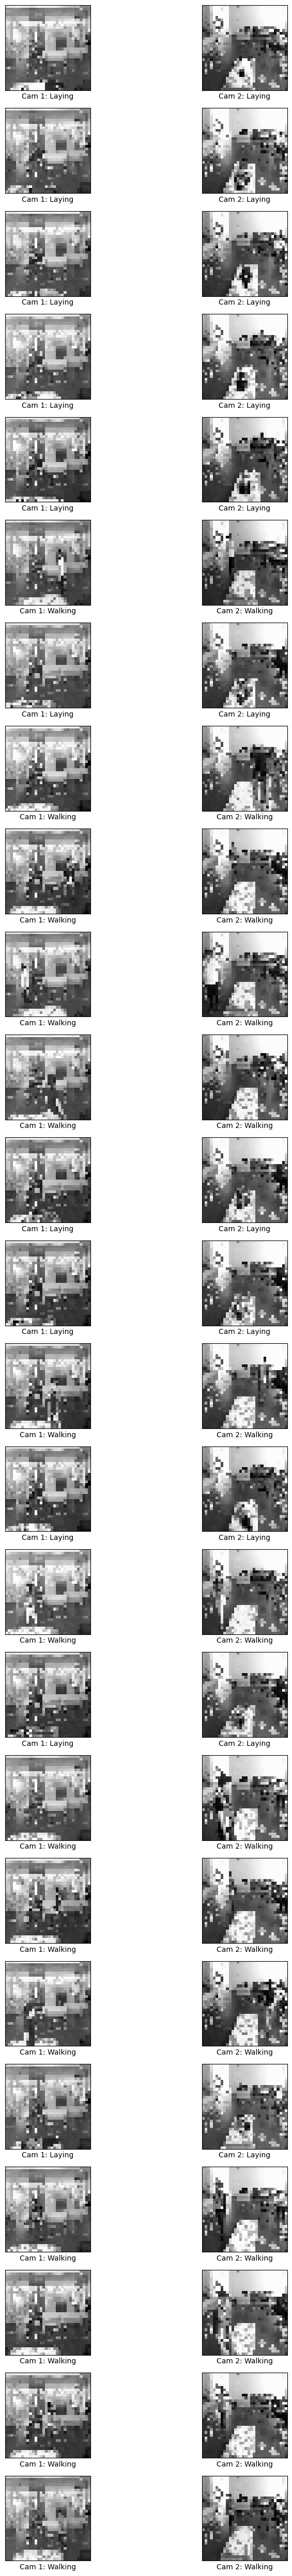

In [11]:
# Define class names
class_name = [  
    '?',
    'Falling hands',
    'Falling knees',
    'Falling backwards',
    'Falling sideward',
    'Falling chair',
    'Walking',
    'Standing',
    'Sitting',
    'Picking object',
    'Jumping',
    'Laying'
]

# Randomly select 25 indices
random_indices = np.random.choice(len(cam_1), size=25, replace=False)

# Prepare the figure: 25 rows, 2 columns (cam_1 and cam_2)
plt.figure(figsize=(10, 50))

for i, idx in enumerate(random_indices):
    # cam_1 image
    ax1 = plt.subplot(25, 2, 2*i + 1)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.grid(False)
    ax1.imshow(cam_1[idx], cmap='gray')
    label_text = class_name[label_1[idx]] if label_1[idx] < len(class_name) else 'Unknown'
    ax1.set_xlabel(f'Cam 1: {label_text}')

    # cam_2 image
    ax2 = plt.subplot(25, 2, 2*i + 2)
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.grid(False)
    ax2.imshow(cam_2[idx], cmap='gray')
    label_text = class_name[label_2[idx]] if label_2[idx] < len(class_name) else 'Unknown'
    ax2.set_xlabel(f'Cam 2: {label_text}')

plt.tight_layout()
plt.show()

In [12]:
# Ensure all arrays are NumPy arrays
cam_1 = np.array(cam_1)
cam_2 = np.array(cam_2)
label_1 = np.array(label_1)
label_2 = np.array(label_2)
name_1 = np.array(name_1)
name_2 = np.array(name_2)

# Create indices for splitting to ensure consistency across all arrays
indices = np.arange(len(cam_1))

# Split indices into training and testing sets (80% train, 20% test)
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42, shuffle=True)

# Apply split to all arrays using the same indices
cam_1_train, cam_1_test = cam_1[train_idx], cam_1[test_idx]
cam_2_train, cam_2_test = cam_2[train_idx], cam_2[test_idx]
label_1_train, label_1_test = label_1[train_idx], label_1[test_idx]
label_2_train, label_2_test = label_2[train_idx], label_2[test_idx]
name_1_train, name_1_test = name_1[train_idx], name_1[test_idx]
name_2_train, name_2_test = name_2[train_idx], name_2[test_idx]

# ✅ Check result
print(f"Train size: {len(train_idx)} samples")
print(f"Test size: {len(test_idx)} samples")

Train size: 18753 samples
Test size: 4689 samples


In [26]:
def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed()

In [28]:
# Stratified train-test split
train_idx, test_idx = train_test_split(
    np.arange(len(label_1)),
    test_size=0.2,
    stratify=label_1,
    random_state=42
)

cam_1_train, cam_1_test = cam_1[train_idx], cam_1[test_idx]
cam_2_train, cam_2_test = cam_2[train_idx], cam_2[test_idx]
label_1_train, label_1_test = label_1[train_idx], label_1[test_idx]

In [29]:
cam_1_train = cam_1_train.reshape(-1, 32, 32, 1).astype("float32") / 255.0
cam_2_train = cam_2_train.reshape(-1, 32, 32, 1).astype("float32") / 255.0
cam_1_test = cam_1_test.reshape(-1, 32, 32, 1).astype("float32") / 255.0
cam_2_test = cam_2_test.reshape(-1, 32, 32, 1).astype("float32") / 255.0

num_classes = np.max(label_1_train) + 1
y_train = to_categorical(label_1_train, num_classes)
y_test = to_categorical(label_1_test, num_classes)

In [46]:
def build_flexible_model(input_shape, num_classes, mode='combined'):
    def cnn_branch(name_suffix):
        inp = tf.keras.Input(shape=input_shape, name=f"input_{name_suffix}")
        x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', name=f"conv_{name_suffix}")(inp)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D((2, 2))(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(200, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        return inp, x

    if mode == 'cam_1':
        input1, branch1 = cnn_branch("cam1")
        output = tf.keras.layers.Dense(num_classes, activation='softmax')(branch1)
        model = tf.keras.Model(inputs=input1, outputs=output)

    elif mode == 'cam_2':
        input2, branch2 = cnn_branch("cam2")
        output = tf.keras.layers.Dense(num_classes, activation='softmax')(branch2)
        model = tf.keras.Model(inputs=input2, outputs=output)

    elif mode == 'combined':
        input1, branch1 = cnn_branch("cam1")
        input2, branch2 = cnn_branch("cam2")
        merged = tf.keras.layers.Concatenate()([branch1, branch2])
        output = tf.keras.layers.Dense(num_classes, activation='softmax')(merged)
        model = tf.keras.Model(inputs=[input1, input2], outputs=output)

    else:
        raise ValueError("Invalid mode. Choose from 'cam_1', 'cam_2', or 'combined'.")

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=[
            tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )
    return model


In [55]:
input_shape = (32, 32, 1)

model_cam1 = build_flexible_model(input_shape, num_classes, mode='cam_1')

history = model_cam1.fit(
    cam_1_train, y_train,
    validation_data=(cam_1_test, y_test),
    epochs=30,
    batch_size=32
)

Epoch 1/30
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8610 - loss: 0.5334 - precision: 0.9020 - recall: 0.8294 - val_accuracy: 0.9280 - val_loss: 0.3299 - val_precision: 0.9811 - val_recall: 0.8270
Epoch 2/30
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9484 - loss: 0.1719 - precision: 0.9622 - recall: 0.9346 - val_accuracy: 0.9472 - val_loss: 0.1595 - val_precision: 0.9604 - val_recall: 0.9347
Epoch 3/30
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9602 - loss: 0.1280 - precision: 0.9687 - recall: 0.9510 - val_accuracy: 0.9472 - val_loss: 0.1593 - val_precision: 0.9566 - val_recall: 0.9408
Epoch 4/30
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9694 - loss: 0.1000 - precision: 0.9747 - recall: 0.9639 - val_accuracy: 0.9102 - val_loss: 0.2590 - val_precision: 0.9229 - val_recall: 0.8925
Epoch 5/30
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9706 - loss: 0.0862 - precision: 0.9758 - recall: 0.9677 - val_accuracy: 0.9707 - val_loss: 0.

In [56]:
y_pred = model_cam1.predict(cam_1_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# 2. Classification Report
print("\n📊 Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, digits=4))

# 3. Weighted F1 Score
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
print(f"🎯 Weighted F1 Score: {f1:.4f}")

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

📊 Classification Report:
              precision    recall  f1-score   support

           1     0.8767    0.7356    0.8000        87
           2     0.9205    0.8020    0.8571       101
           3     0.8571    0.7500    0.8000       104
           4     0.8571    0.7606    0.8060        71
           5     0.8864    0.8478    0.8667        92
           6     0.9988    1.0000    0.9994      2558
           7     0.9444    0.9808    0.9623       208
          11     0.9699    0.9979    0.9837      1421

    accuracy                         0.9769      4642
   macro avg     0.9139    0.8593    0.8844      4642
weighted avg     0.9760    0.9769    0.9760      4642

🎯 Weighted F1 Score: 0.9760


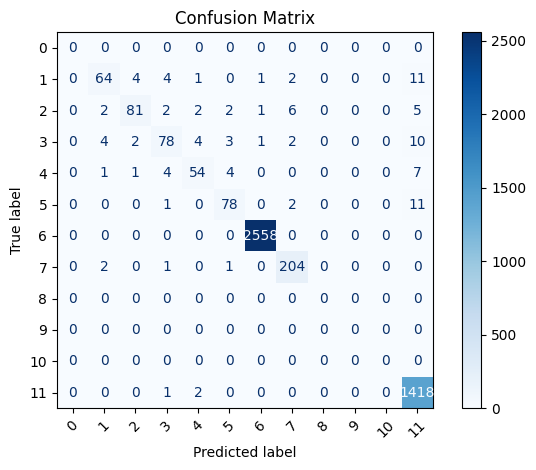

In [59]:
labels = list(range(num_classes))  # or your class_names if available

cm = confusion_matrix(y_true_classes, y_pred_classes, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


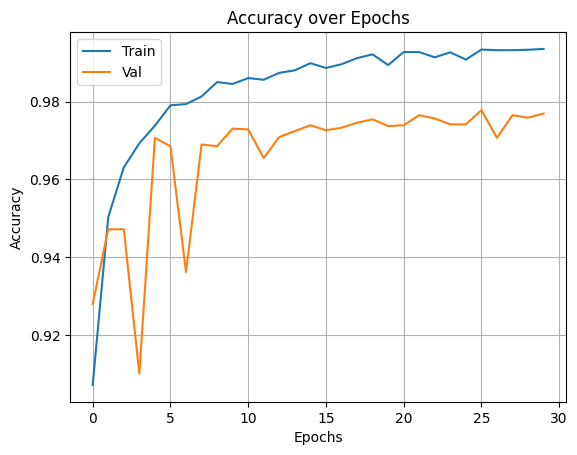

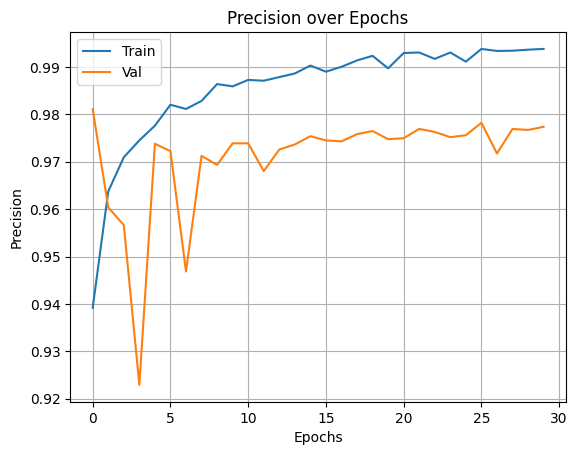

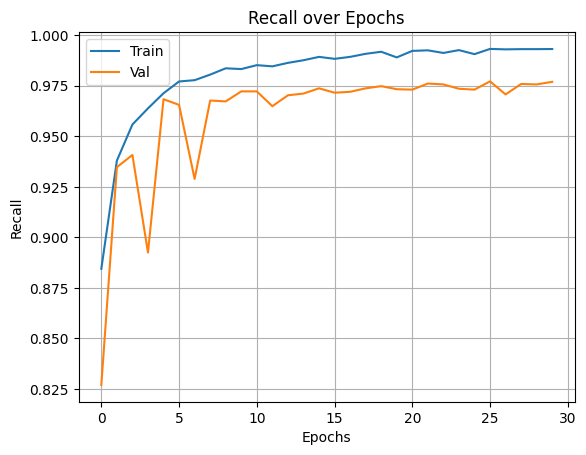

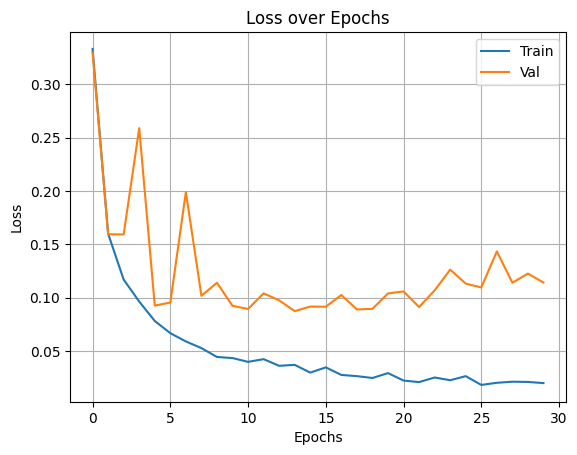

In [60]:
def plot_training_metric(history, metric):
    if metric in history.history:
        plt.plot(history.history[metric], label='Train')
        plt.plot(history.history['val_' + metric], label='Val')
        plt.title(f'{metric.capitalize()} over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid(True)
        plt.show()

for metric in ['accuracy', 'precision', 'recall', 'loss']:
    plot_training_metric(history, metric)


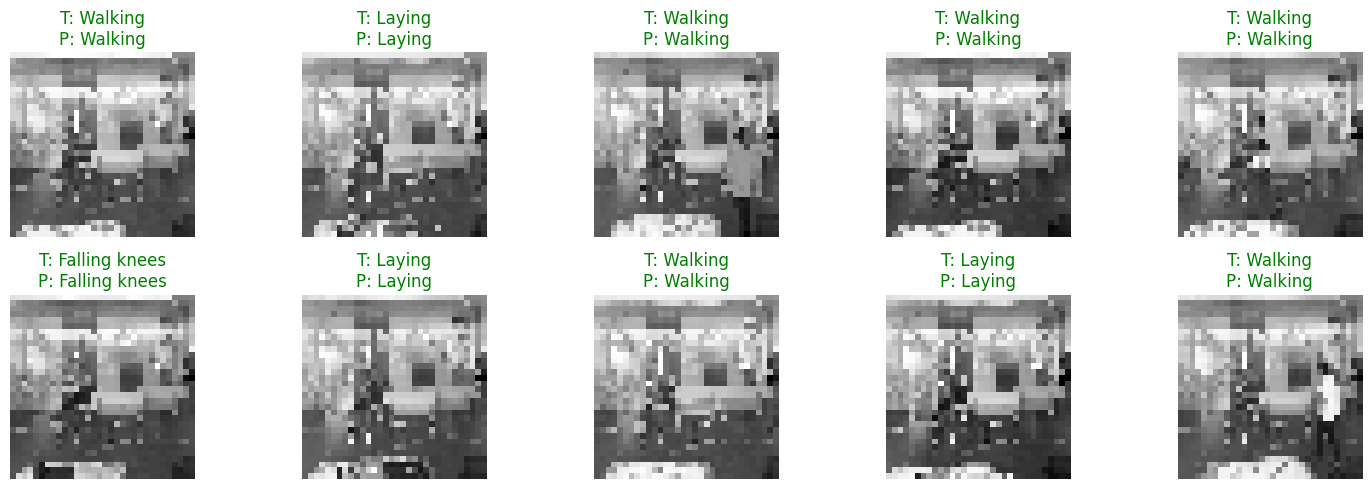

In [61]:
N = 10
indices = np.random.choice(len(cam_1_test), size=N, replace=False)

plt.figure(figsize=(15, 5))
for i, idx in enumerate(indices):
    ax = plt.subplot(2, N // 2, i + 1)
    img = cam_1_test[idx].squeeze()
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    true_label = class_name[y_true_classes[idx]]
    pred_label = class_name[y_pred_classes[idx]]
    color = "green" if true_label == pred_label else "red"
    ax.set_title(f"T: {true_label}\nP: {pred_label}", color=color)

plt.tight_layout()
plt.show()


In [62]:
model_cam1.save("model_cam1.keras")

In [63]:
input_shape = (32, 32, 1)

model_cam2 = build_flexible_model(input_shape, num_classes, mode='cam_2')

history = model_cam2.fit(
    cam_2_train, y_train,
    validation_data=(cam_2_test, y_test),
    epochs=30,
    batch_size=32
)

Epoch 1/30
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8716 - loss: 0.4865 - precision: 0.9117 - recall: 0.8471 - val_accuracy: 0.9505 - val_loss: 0.2273 - val_precision: 0.9699 - val_recall: 0.9024
Epoch 2/30
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9591 - loss: 0.1223 - precision: 0.9657 - recall: 0.9532 - val_accuracy: 0.9625 - val_loss: 0.1073 - val_precision: 0.9670 - val_recall: 0.9582
Epoch 3/30
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9693 - loss: 0.0914 - precision: 0.9725 - recall: 0.9656 - val_accuracy: 0.9673 - val_loss: 0.0889 - val_precision: 0.9684 - val_recall: 0.9649
Epoch 4/30
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9755 - loss: 0.0705 - precision: 0.9767 - recall: 0.9737 - val_accuracy: 0.9778 - val_loss: 0.0687 - val_precision: 0.9780 - val_recall: 0.9772
Epoch 5/30
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9807 - loss: 0.0547 - precision: 0.9818 - recall: 0.9791 - val_accuracy: 0.9741 - val_loss: 0.

In [64]:
y_pred = model_cam1.predict(cam_1_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# 2. Classification Report
print("\n📊 Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, digits=4))

# 3. Weighted F1 Score
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
print(f"🎯 Weighted F1 Score: {f1:.4f}")

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

📊 Classification Report:
              precision    recall  f1-score   support

           1     0.8767    0.7356    0.8000        87
           2     0.9205    0.8020    0.8571       101
           3     0.8571    0.7500    0.8000       104
           4     0.8571    0.7606    0.8060        71
           5     0.8864    0.8478    0.8667        92
           6     0.9988    1.0000    0.9994      2558
           7     0.9444    0.9808    0.9623       208
          11     0.9699    0.9979    0.9837      1421

    accuracy                         0.9769      4642
   macro avg     0.9139    0.8593    0.8844      4642
weighted avg     0.9760    0.9769    0.9760      4642

🎯 Weighted F1 Score: 0.9760


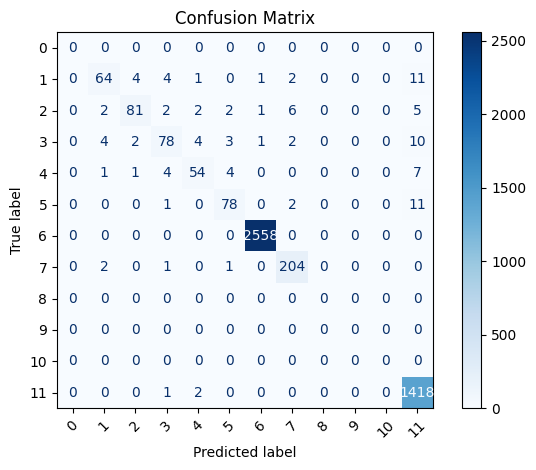

In [65]:
labels = list(range(num_classes))

cm = confusion_matrix(y_true_classes, y_pred_classes, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


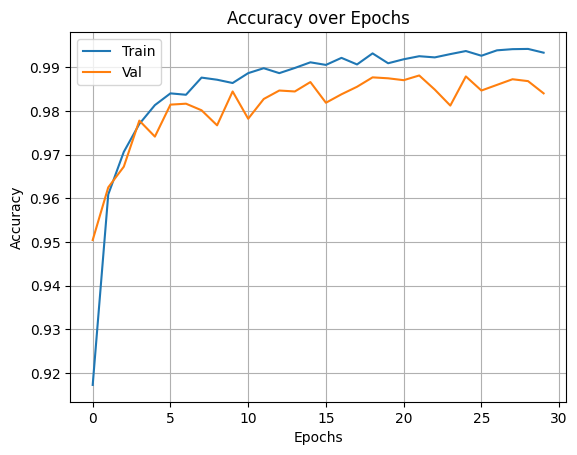

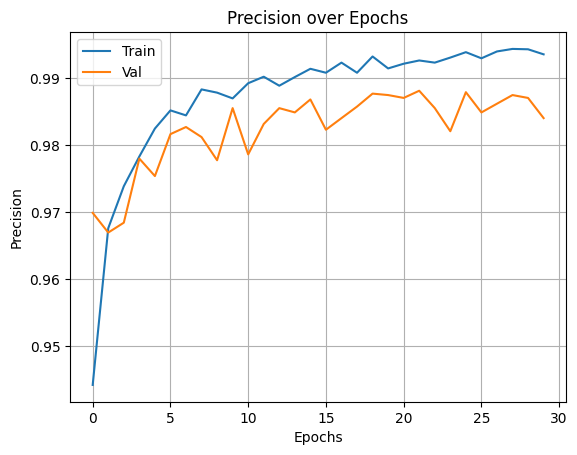

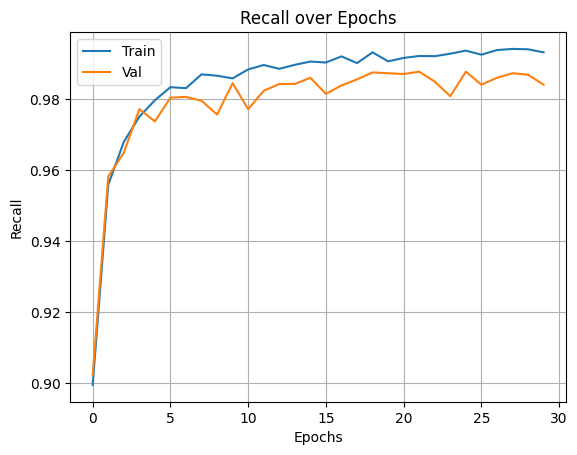

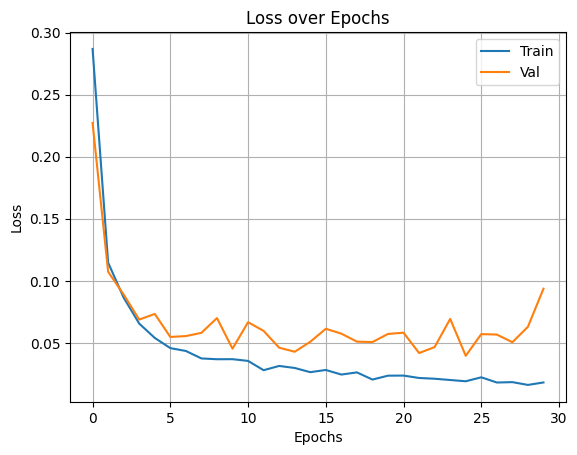

In [66]:
def plot_training_metric(history, metric):
    if metric in history.history:
        plt.plot(history.history[metric], label='Train')
        plt.plot(history.history['val_' + metric], label='Val')
        plt.title(f'{metric.capitalize()} over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid(True)
        plt.show()

for metric in ['accuracy', 'precision', 'recall', 'loss']:
    plot_training_metric(history, metric)


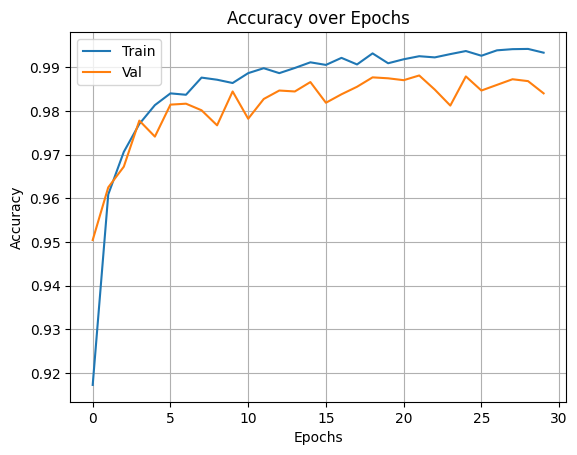

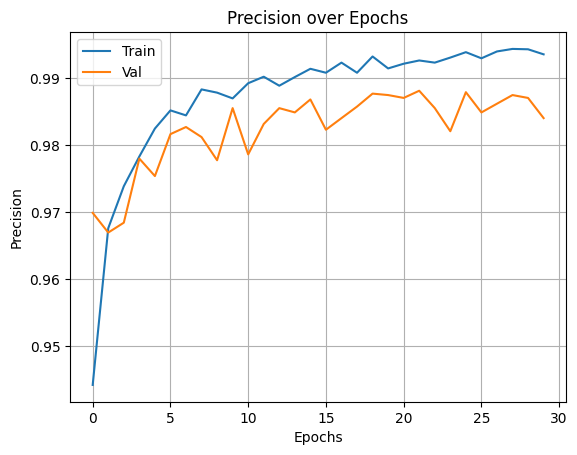

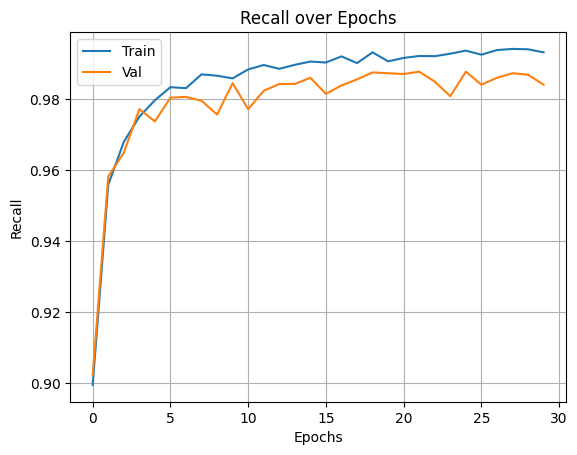

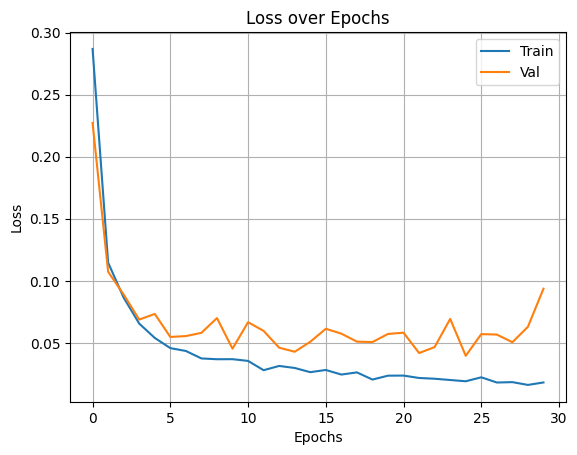

In [67]:
def plot_training_metric(history, metric):
    if metric in history.history:
        plt.plot(history.history[metric], label='Train')
        plt.plot(history.history['val_' + metric], label='Val')
        plt.title(f'{metric.capitalize()} over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid(True)
        plt.show()

for metric in ['accuracy', 'precision', 'recall', 'loss']:
    plot_training_metric(history, metric)


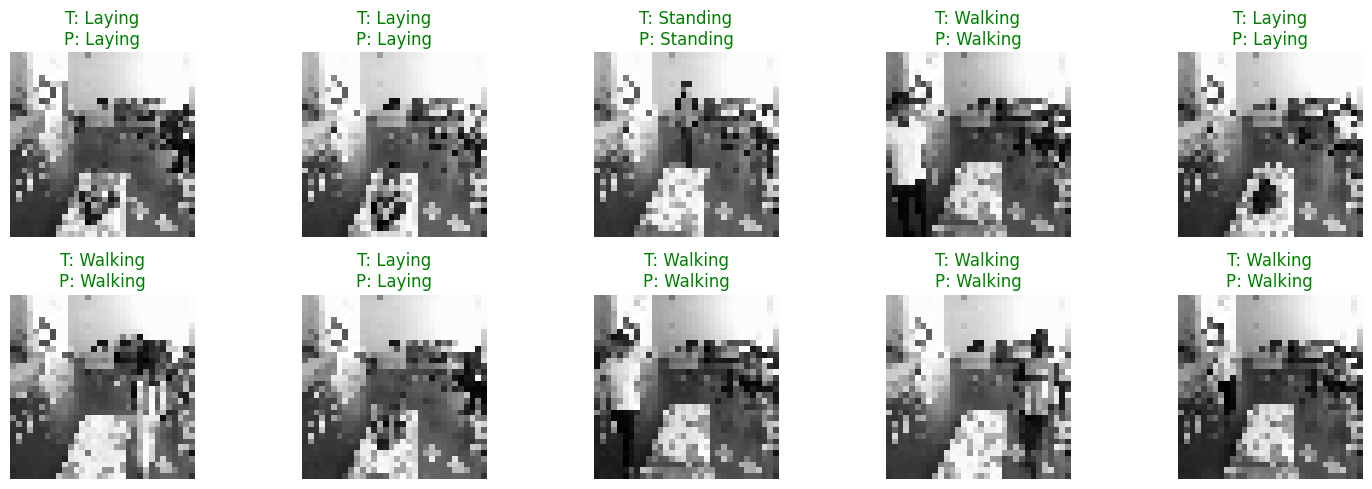

In [85]:
N = 10
indices = np.random.choice(len(cam_2_test), size=N, replace=False)

plt.figure(figsize=(15, 5))
for i, idx in enumerate(indices):
    ax = plt.subplot(2, N // 2, i + 1)
    img = cam_2_test[idx].squeeze()
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    true_label = class_name[y_true_classes[idx]]
    pred_label = class_name[y_pred_classes[idx]]
    color = "green" if true_label == pred_label else "red"
    ax.set_title(f"T: {true_label}\nP: {pred_label}", color=color)

plt.tight_layout()
plt.show()


In [69]:
model_cam1.save("model_cam2.keras")

In [70]:
input_shape = (32, 32, 1)

model_combined = build_flexible_model(input_shape, num_classes, mode='combined')

history = model_combined.fit(
    [cam_1_train, cam_2_train],
    y_train,
    validation_data=([cam_1_test, cam_2_test], y_test),
    epochs=30
)

Epoch 1/30
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8702 - loss: 0.5777 - precision: 0.9097 - recall: 0.8475 - val_accuracy: 0.9489 - val_loss: 0.2353 - val_precision: 0.9754 - val_recall: 0.8888
Epoch 2/30
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9652 - loss: 0.1067 - precision: 0.9716 - recall: 0.9599 - val_accuracy: 0.9696 - val_loss: 0.0878 - val_precision: 0.9712 - val_recall: 0.9655
Epoch 3/30
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9758 - loss: 0.0711 - precision: 0.9773 - recall: 0.9737 - val_accuracy: 0.9793 - val_loss: 0.0609 - val_precision: 0.9806 - val_recall: 0.9782
Epoch 4/30
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9836 - loss: 0.0503 - precision: 0.9850 - recall: 0.9818 - val_accuracy: 0.9856 - val_loss: 0.0520 - val_precision: 0.9860 - val_recall: 0.9849
Epoch 5/30
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9874 - loss: 0.0387 - precision: 0.9880 - recall: 0.9872 - val_accuracy: 0.9836 - val_loss: 0.

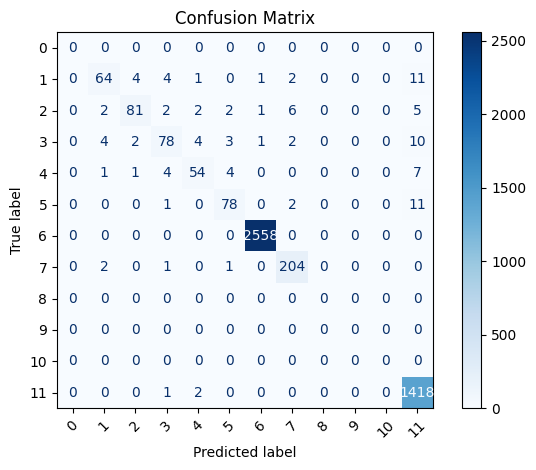

In [71]:
labels = list(range(num_classes))

cm = confusion_matrix(y_true_classes, y_pred_classes, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


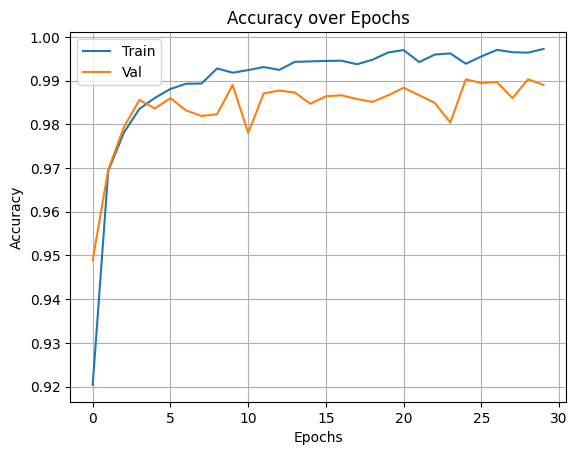

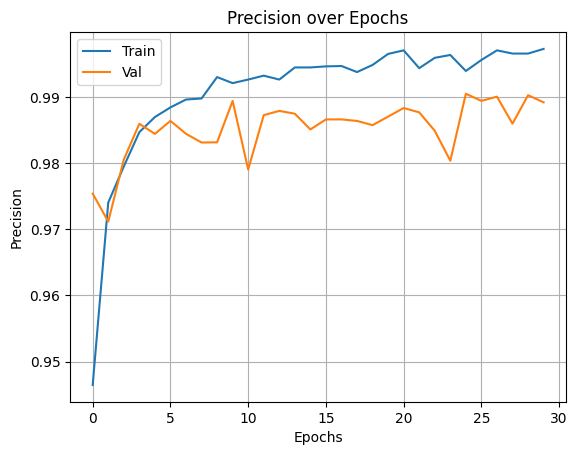

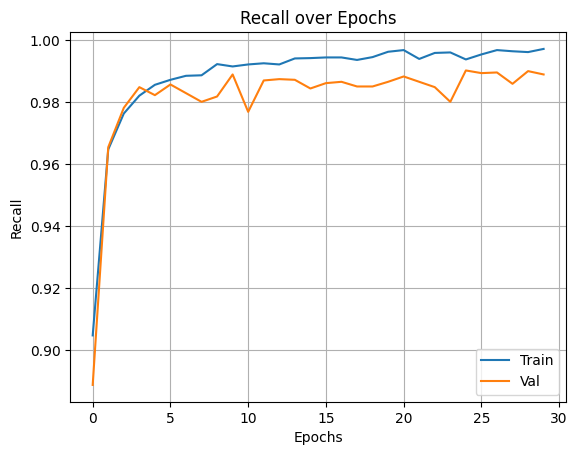

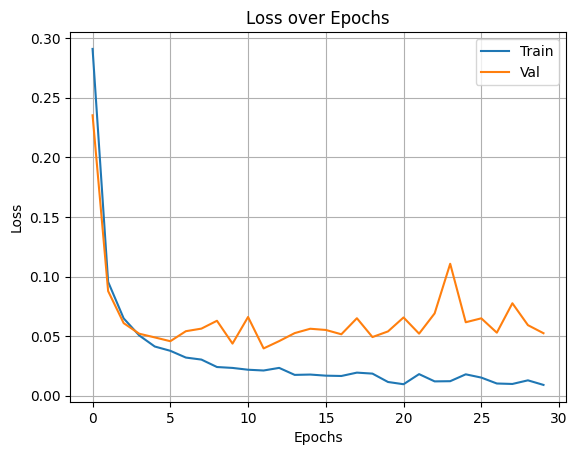

In [72]:
def plot_training_metric(history, metric):
    if metric in history.history:
        plt.plot(history.history[metric], label='Train')
        plt.plot(history.history['val_' + metric], label='Val')
        plt.title(f'{metric.capitalize()} over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid(True)
        plt.show()

for metric in ['accuracy', 'precision', 'recall', 'loss']:
    plot_training_metric(history, metric)


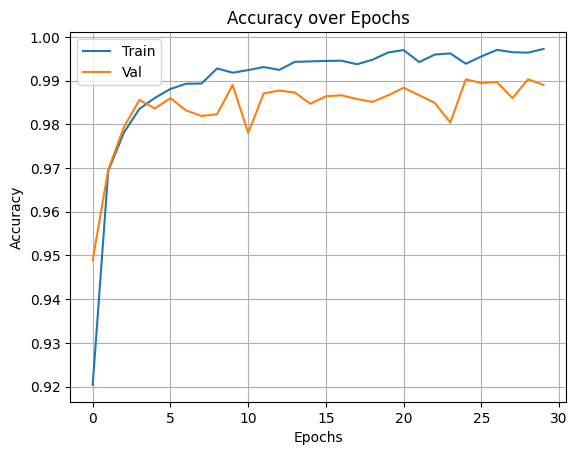

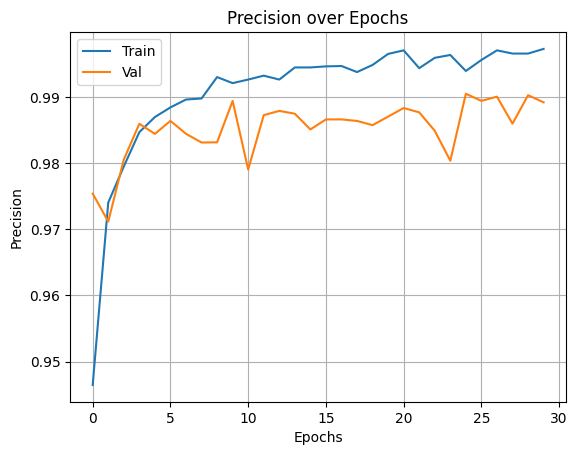

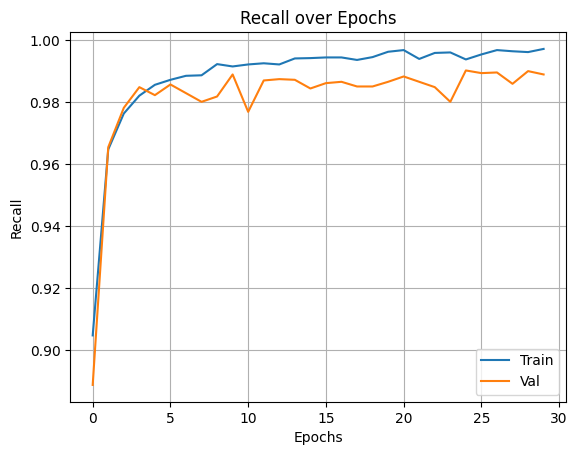

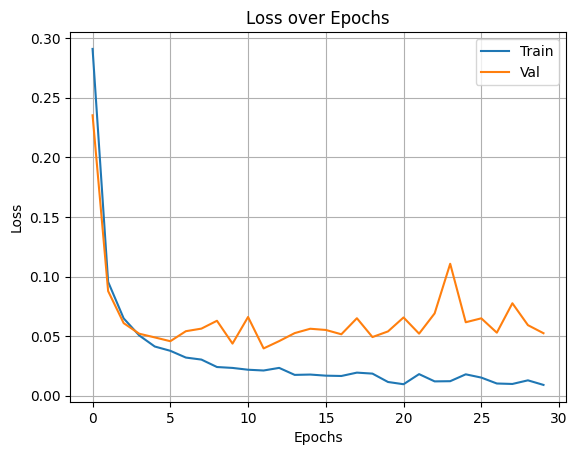

In [73]:
def plot_training_metric(history, metric):
    if metric in history.history:
        plt.plot(history.history[metric], label='Train')
        plt.plot(history.history['val_' + metric], label='Val')
        plt.title(f'{metric.capitalize()} over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid(True)
        plt.show()

for metric in ['accuracy', 'precision', 'recall', 'loss']:
    plot_training_metric(history, metric)


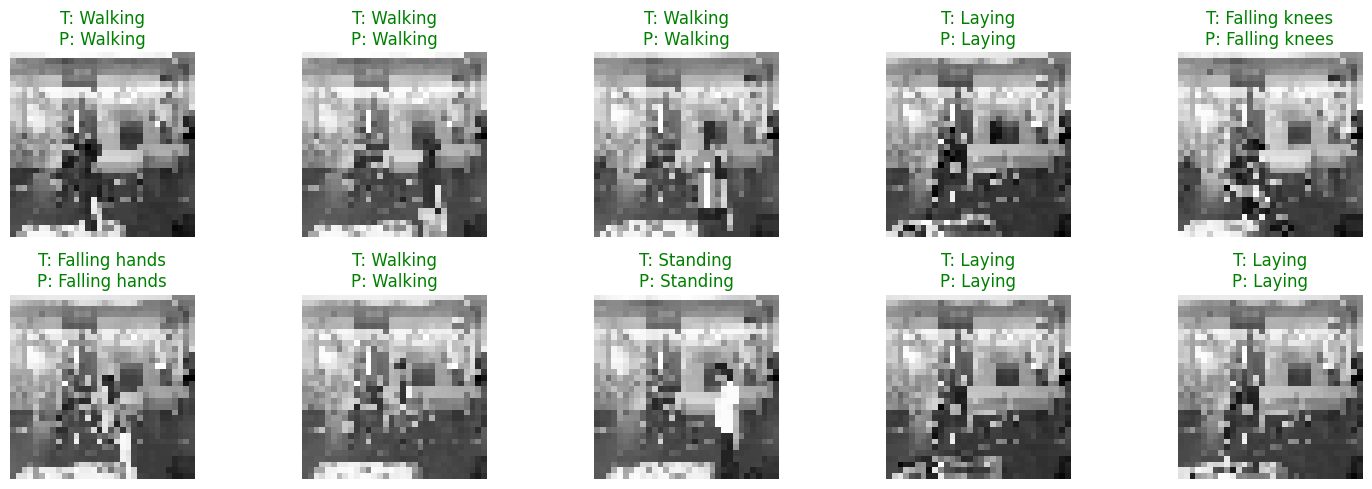

In [74]:
N = 10
indices = np.random.choice(len(cam_1_test), size=N, replace=False)

plt.figure(figsize=(15, 5))
for i, idx in enumerate(indices):
    ax = plt.subplot(2, N // 2, i + 1)
    img = cam_1_test[idx].squeeze()
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    true_label = class_name[y_true_classes[idx]]
    pred_label = class_name[y_pred_classes[idx]]
    color = "green" if true_label == pred_label else "red"
    ax.set_title(f"T: {true_label}\nP: {pred_label}", color=color)

plt.tight_layout()
plt.show()


In [75]:
model_cam1.save("model_combined.keras")